In [1]:
import numpy as np
import cv2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from ProblemSet import ProblemSet

In [66]:
# Allowable libraries:
# - Python 3.10.12
# - Pillow 10.0.0
# - numpy 1.25.2
# - OpenCV 4.6.0 (with opencv-contrib-python-headless 4.6.0.66)

# To activate image processing, uncomment the following imports:
# from PIL import Image
import numpy as np
import cv2

class Agent:
    def __init__(self):
        """
        The default constructor for your Agent. Make sure to execute any processing necessary before your Agent starts
        solving problems here. Do not add any variables to this signature; they will not be used by main().
        
        This init method is only called once when the Agent is instantiated 
        while the Solve method will be called multiple times. 
        """
        pass

    def Solve(self, problem):
        """
        Primary method for solving incoming Raven's Progressive Matrices.

        Args:
            problem: The RavensProblem instance.

        Returns:
            int: The answer (1-6 for 2x2 OR 1-8 for 3x3).
            Return a negative number to skip a problem.
            Remember to return the answer [Key], not the name, as the ANSWERS ARE SHUFFLED in Gradescope.
        """

        '''
        DO NOT use absolute file pathing to open files.
        
        Example: Read the 'A' figure from the problem using Pillow
            image_a = Image.open(problem.figures["A"].visualFilename)
            
        Example: Read the '1' figure from the problem using OpenCv
            image_1 = cv2.imread(problem.figures["1"].visualFilename)
            
        Don't forget to uncomment the import!
        '''

        if problem.problemType == "3x3":
            my_answer = self.tackle_3x3(problem)

        return my_answer if my_answer else 7
    
    def tackle_3x3(self, problem):

        self.image_dict = {}
        for image_id in range(ord('A'), ord('H') + 1):
            self.image_dict[chr(image_id)] = cv2.imread(problem.figures[chr(image_id)].visualFilename)

        self.answer_list = [cv2.imread(problem.figures[str(index)].visualFilename) for index in range(1, 9)]
        
        candidate_list = [
            self.pixel_count_diff_3x3(),
            self.pixel_percent_chage_3x3(),
            self.flip_3x3(),
            # self.trixor_3x3(),
            self.sim_group_3x3(),
            self.and_3x3(),
            # self.subtract_3x3(),
            self.xor_3x3(),
            self.intersect_3x3()
        ]
        
        print(candidate_list)
        answer = get_best_answer_3x3(candidate_list)

        return answer
    
    def trixor_3x3(self):

        answer, prob = None, None
        best_combo = min(grouped_combinations, key=lambda combo: self.get_triple_xor_diff(combo[0])[0])
        picked, rest = best_combo[0], best_combo[1]
        triple_xor_diff, pixel_count_target = self.get_triple_xor_diff(picked)
        if triple_xor_diff <= 0.05:
            answer_index = min(range(len(self.answer_list)), key=lambda answer_id: get_diff(pixel_count_target, count_black_pixel(triple_xor(self.answer_list[answer_id], self.image_dict[rest[0]], self.image_dict[rest[1]]))))
            prob = 0.8 - get_diff(pixel_count_target, count_black_pixel(triple_xor(self.answer_list[answer_index], self.image_dict[rest[0]], self.image_dict[rest[1]])))
            answer = answer_index+1
        return answer, prob
    
    def sim_group_3x3(self):

        answer, prob = None, None
        best_combo = min(grouped_combinations, key=lambda combo: self.get_triple_xor_sum(combo[0]))
        picked, rest = best_combo[0], best_combo[1]
        triple_xor_sum = self.get_triple_xor_sum(picked)

        if triple_xor_sum <= 3000:
            answer_index = min(range(len(self.answer_list)), key=lambda answer_id: count_black_pixel(triple_xor(self.answer_list[answer_id], self.image_dict[rest[0]], self.image_dict[rest[1]])))
            prob = 1 - count_black_pixel(triple_xor(self.answer_list[answer_index], self.image_dict[rest[0]], self.image_dict[rest[1]])) / 184 ** 2
            answer = answer_index+1
        return answer, prob


    def get_triple_xor_diff(self, combo):

        (id1, id2, id3), (id4, id5, id6) = combo
        img1, img2, img3, img4, img5, img6 = self.image_dict[id1], self.image_dict[id2], self.image_dict[id3], self.image_dict[id4], self.image_dict[id5], self.image_dict[id6]
        trixor1 = triple_xor(img1, img2, img3)
        trixor2 = triple_xor(img4, img5, img6)
        pc_trixor1, pc_trixor2 = count_black_pixel(trixor1), count_black_pixel(trixor2)
        
        return get_diff(pc_trixor1, pc_trixor2), (pc_trixor1+pc_trixor2)/2

    def get_triple_xor_sum(self, combo):

        (id1, id2, id3), (id4, id5, id6) = combo
        img1, img2, img3, img4, img5, img6 = self.image_dict[id1], self.image_dict[id2], self.image_dict[id3], self.image_dict[id4], self.image_dict[id5], self.image_dict[id6]
        trixor1 = triple_xor(img1, img2, img3)
        trixor2 = triple_xor(img4, img5, img6)
        pc_trixor = count_black_pixel(trixor1) + count_black_pixel(trixor2)
        
        return pc_trixor

    def intersect_3x3(self):

        answer, prob = None, None
        candidate_img = get_candidate_intersect_3x3(self.image_dict)
        if candidate_img is not None:
            answer_sim_list = [similarity(answer, candidate_img) for answer in self.answer_list]
            prob = max(answer_sim_list)
            answer = answer_sim_list.index(prob) + 1

        return (answer, prob)

    def subtract_3x3(self):

        answer, prob = None, None
        pixel_count_target = get_candidate_subtract_3x3(self.image_dict)
        if pixel_count_target: answer, prob = get_answer_pixel(self.answer_list, pixel_count_target)

        return (answer, prob)
    
    def and_3x3(self):

        answer, prob = None, None
        candidate_img = get_candidate_and_3x3(self.image_dict)
        if candidate_img is not None:
            answer_diff_list = [get_diff(count_black_pixel(answer), count_black_pixel(candidate_img)) for answer in self.answer_list]
            min_diff = min(answer_diff_list)
            answer = answer_diff_list.index(min_diff) + 1
            prob = 1 - min_diff

        return (answer, prob)        
    
    def xor_3x3(self):

        answer, prob = None, None
        candidate_img = get_candidate_xor_3x3(self.image_dict)
        if candidate_img is not None:
            answer_sim_list = [-similarity(answer, candidate_img) for answer in self.answer_list]
            prob = max(answer_sim_list)
            answer = answer_sim_list.index(prob) + 1

        return (answer, prob)
    
    def flip_3x3(self):

        answer, prob = None, None
        candidate_img = get_candidate_flip_3x3(self.image_dict)
        if candidate_img is not None:
            answer_sim_list = [similarity(answer, candidate_img) for answer in self.answer_list]
            prob = max(answer_sim_list)
            answer = answer_sim_list.index(prob) + 1

        return (answer, prob)
    
    def pixel_count_diff_3x3(self):

        answer, prob = None, None
        pixel_count_target = get_candidate_pixel_count_3x3(self.image_dict)
        if pixel_count_target: answer, prob = get_answer_pixel(self.answer_list, pixel_count_target)

        return (answer, prob)
    
    def pixel_percent_chage_3x3(self):

        answer, prob = None, None
        pixel_count_target = get_candidate_pixel_rate_3x3(self.image_dict)
        if pixel_count_target: answer, prob = get_answer_pixel(self.answer_list, pixel_count_target)

        return (answer, prob)

def similarity(image1, image2):
    # Calculate the normalized cross-correlation (NCC)
    ncc = cv2.matchTemplate(image1, image2, cv2.TM_CCOEFF_NORMED)
    return min(1, ncc)

def get_best_answer_3x3(candidate_list):

    answer = None 
    candidate_list = [candidate for candidate in candidate_list if candidate[0]]
    if candidate_list:
        bset_answer = max(candidate_list, key=lambda x: x[1])
        answer = bset_answer[0]
    return answer

def count_black_pixel(image, threshold=245):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return (gray_img < threshold).sum()

def get_candidate_pixel_count_3x3(image_dict, threshold=0.05):

    pc_dict = {}
    for image_id, img in image_dict.items():
        pc_dict[image_id] = count_black_pixel(img)
        
    # row 1
    row_1_diff = abs(2 * pc_dict['B'] - pc_dict['A'] - pc_dict['C']) / pc_dict['B']
    # row 2
    row_2_diff = abs(2 * pc_dict['E'] - pc_dict['D'] - pc_dict['F']) / pc_dict['E']

    if row_1_diff <= threshold and row_2_diff <= threshold:
        return 2 * pc_dict['H'] - pc_dict['G']
    
    # col 1
    col_1_diff = abs(2 * pc_dict['D'] - pc_dict['A'] - pc_dict['G']) / pc_dict['D']
    # col 2
    col_2_diff = abs(2 * pc_dict['E'] - pc_dict['B'] - pc_dict['H']) / pc_dict['E']

    if col_1_diff <= threshold and col_2_diff <= threshold:
        return 2 * pc_dict['F'] - pc_dict['C']

def get_candidate_pixel_rate_3x3(image_dict, threshold=0.1):

    pc_dict = {}
    for image_id, img in image_dict.items():
        pc_dict[image_id] = count_black_pixel(img)
        
    # row 1
    AB_diff = pc_dict['B'] / (pc_dict['A'] + 1)
    BC_diff = pc_dict['C'] / (pc_dict['B'] + 1)
    # row 2
    DE_diff = pc_dict['E'] / (pc_dict['D'] + 1)
    EF_diff = pc_dict['F'] / (pc_dict['E'] + 1)

    if get_diff(AB_diff, DE_diff) <= threshold and get_diff(BC_diff, EF_diff) <= threshold:
        return pc_dict['H'] * (BC_diff + EF_diff) / 2
    
    # col 1
    AD_diff = pc_dict['D'] / (pc_dict['A'] + 1)
    DG_diff = pc_dict['G'] / (pc_dict['D'] + 1)
    # col 2
    BE_diff = pc_dict['E'] / (pc_dict['B'] + 1)
    EH_diff = pc_dict['H'] / (pc_dict['E'] + 1)

    if get_diff(AD_diff, BE_diff) <= threshold and get_diff(DG_diff, EH_diff) <= threshold:
        return pc_dict['F'] * (DG_diff + EH_diff) / 2

def get_answer_pixel(answers, pixel_count_target):

    answers_pc = [count_black_pixel(answer) for answer in answers]
    answer_index = min(range(len(answers_pc)), key=lambda i: abs(answers_pc[i] - pixel_count_target))
    answer_pixel_count = answers_pc[answer_index]
  
    prob = 1 - get_diff(answer_pixel_count, pixel_count_target)
  
    return answer_index + 1, prob

def get_diff(mun1, mun2):

    return 1 - min(mun1, mun2) / max(mun1, mun2)

def get_candidate_intersect_3x3(image_dict, threshold=0.15):

    # row inter
    inter_AB = intersection(image_dict['A'], image_dict['B'])
    inter_DE = intersection(image_dict['D'], image_dict['E'])

    inter_AB_C_sim = similarity(inter_AB, image_dict['C'])
    inter_DE_F_sim = similarity(inter_DE, image_dict['F'])

    if inter_AB_C_sim >= 1 - threshold and inter_DE_F_sim >= 1 - threshold:
        return intersection(image_dict['G'], image_dict['H'])

    # col inter
    inter_AD = intersection(image_dict['A'], image_dict['D'])
    inter_BE = intersection(image_dict['B'], image_dict['E'])

    inter_AD_G_sim = similarity(inter_AD, image_dict['G'])
    inter_BE_H_sim = similarity(inter_BE, image_dict['H'])

    if inter_AD_G_sim >= 1 - threshold and inter_BE_H_sim >= 1 - threshold:
        return intersection(image_dict['C'], image_dict['F'])
    

def get_candidate_and_3x3(image_dict, threshold=0.15):

    # row union
    and_AB = cv2.bitwise_and(image_dict['A'], image_dict['B'])
    and_DE = cv2.bitwise_and(image_dict['D'], image_dict['E'])

    and_AB_C_sim = similarity(and_AB, image_dict['C'])
    and_DE_F_sim = similarity(and_DE, image_dict['F'])

    if and_AB_C_sim >= 1 - threshold and and_DE_F_sim >= 1 - threshold:
        return cv2.bitwise_and(image_dict['G'], image_dict['H'])

    # col union
    and_AD = cv2.bitwise_and(image_dict['A'], image_dict['D'])
    and_BE = cv2.bitwise_and(image_dict['B'], image_dict['E'])

    and_AD_G_sim = similarity(and_AD, image_dict['G'])
    and_BE_H_sim = similarity(and_BE, image_dict['H'])

    if and_AD_G_sim >= 1 - threshold and and_BE_H_sim >= 1 - threshold:
        return cv2.bitwise_and(image_dict['C'], image_dict['F'])
    
def get_candidate_xor_3x3(image_dict, threshold=0.25):

    # row union
    xor_AB = cv2.bitwise_xor(image_dict['A'], image_dict['B'])
    xor_DE = cv2.bitwise_xor(image_dict['D'], image_dict['E'])

    xor_AB_C_sim = -similarity(xor_AB, image_dict['C'])
    xor_DE_F_sim = -similarity(xor_DE, image_dict['F'])
    if xor_AB_C_sim >= 1 - threshold and xor_DE_F_sim >= 1 - threshold:
        return cv2.bitwise_xor(image_dict['G'], image_dict['H'])

    # col union
    xor_AD = cv2.bitwise_xor(image_dict['A'], image_dict['D'])
    xor_BE = cv2.bitwise_xor(image_dict['B'], image_dict['E'])

    xor_AD_G_sim = -similarity(xor_AD, image_dict['G'])
    xor_BE_H_sim = -similarity(xor_BE, image_dict['H'])

    if xor_AD_G_sim >= 1 - threshold and xor_BE_H_sim >= 1 - threshold:
        return cv2.bitwise_xor(image_dict['C'], image_dict['F'])

def get_candidate_flip_3x3(image_dict, threshold=0.05):

    # horizontal flip
    hflip_A = cv2.flip(image_dict['A'], 1)
    hflip_D = cv2.flip(image_dict['D'], 1)
    AC_sim = similarity(hflip_A, image_dict['C'])
    DF_sim = similarity(hflip_D, image_dict['F'])

    if AC_sim >= 1 - threshold and DF_sim >= 1 - threshold:
        return cv2.flip(image_dict['G'], 1)

    # vertical flip
    hflip_A = cv2.flip(image_dict['A'], 0)
    hflip_B = cv2.flip(image_dict['B'], 0)
    AG_sim = similarity(hflip_A, image_dict['G'])
    BH_sim = similarity(hflip_B, image_dict['H'])

    if AG_sim >= 1 - threshold and BH_sim >= 1 - threshold:
        return cv2.flip(image_dict['C'], 0)

def get_candidate_subtract_3x3(image_dict, threshold=0.05):

    pc_dict = {}
    for image_id, img in image_dict.items():
        pc_dict[image_id] = count_black_pixel(img)
        
    # row 1
    row_1_diff = pc_dict['A'] - pc_dict['B'] - pc_dict['C']
    # row 2
    row_2_diff = pc_dict['D'] - pc_dict['E'] - pc_dict['F']

    if row_1_diff <= threshold and row_2_diff <= threshold:
        return pc_dict['G'] - pc_dict['H']
    
    # col 1
    row_1_diff = pc_dict['A'] - pc_dict['D'] - pc_dict['G']
    # col 2
    row_2_diff = pc_dict['B'] - pc_dict['E'] - pc_dict['H']

    if row_1_diff <= threshold and row_2_diff <= threshold:
        return pc_dict['C'] - pc_dict['F']

def intersection(img1, img2):
    intersec_pixels = np.all(img1 == 255, axis=2) | np.all(img2 == 255, axis=2) 
    output = np.zeros_like(img1)
    output[intersec_pixels] = [[255, 255, 255]]

    return output

from itertools import combinations

chars = "ABCDEFGH"
combinations_of_3 = list(combinations(chars, 3))

grouped_combinations = []  # Using a set to avoid duplicate groupings

for i in range(len(combinations_of_3)):
    for j in range(i+1, len(combinations_of_3)):
        # Check that there are no overlapping characters
        if not any(char in combinations_of_3[i] for char in combinations_of_3[j]):
            # Remaining characters will be the third group
            remaining = set(chars) - set(combinations_of_3[i]) - set(combinations_of_3[j])
            third_group = tuple(sorted(remaining))
            # Sorting the groups to avoid different orders
            combo = tuple([(combinations_of_3[i], combinations_of_3[j]), third_group])
            grouped_combinations.append(combo)

def triple_xor(img1, img2, img3):
    
    similar_pixels = np.all(img1 == img2, axis=2) & np.all(img2 == img3, axis=2)
    output = np.zeros_like(img1)
    output[similar_pixels] = [[255, 255, 255]]

    return output



In [6]:
my_agent = Agent()

In [70]:
basic = ProblemSet('Basic Problems D')
basic.loadProblemSet()

challenge = ProblemSet('Challenge Problems D')
challenge.loadProblemSet()

In [71]:
my_agent = Agent()

In [72]:
for problem in basic.problems[:12]:
    print (problem.answer, my_agent.Solve(problem))

[(3, 1.0), (3, 0.9993664179984935), (None, None), (3, 1.0), (3, 1.0), (None, None), (None, None)]
3 3
[(None, None), (None, None), (None, None), (1, 0.9603024574669187), (None, None), (None, None), (None, None)]
1 1
[(None, None), (None, None), (None, None), (3, 0.9909026465028355), (None, None), (None, None), (None, None)]
3 3
[(None, None), (1, 0.9740141655792824), (None, None), (None, None), (None, None), (None, None), (None, None)]
1 1
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
7 7
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (6, array([[0.939847]], dtype=float32))]
1 6
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
1 7
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
4 7
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
3 7
[(None, None),

In [12]:
image_dict={}
for image_id in range(ord('A'), ord('H') + 1):
    image_dict[chr(image_id)] = cv2.imread(problem.figures[chr(image_id)].visualFilename)

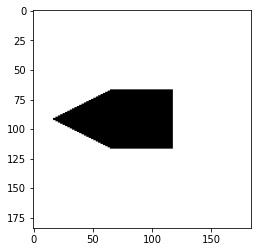

In [34]:
plt.imshow(output)

In [429]:
def get_triple_xor_sum(combo):

    (id1, id2, id3), (id4, id5, id6) = combo
    img1, img2, img3, img4, img5, img6 = image_dict[id1], image_dict[id2], image_dict[id3], image_dict[id4], image_dict[id5], image_dict[id6]
    trixor1 = triple_xor(img1, img2, img3)
    trixor2 = triple_xor(img4, img5, img6)
    pc_trixor = count_black_pixel(trixor1) + count_black_pixel(trixor2)
    
    return pc_trixor


In [436]:
for problem in basic.problems[:12]:
    image_dict = {}
    for image_id in range(ord('A'), ord('H') + 1):
        image_dict[chr(image_id)] = cv2.imread(problem.figures[chr(image_id)].visualFilename)

    answer_list = [cv2.imread(problem.figures[str(index)].visualFilename) for index in range(1, 9)]

    answer, prob = None, None
    best_combo = min(grouped_combinations, key=lambda combo: get_triple_xor_sum(combo[0]))
    picked, rest = best_combo[0], best_combo[1]
    print(best_combo)
    triple_xor_sum = get_triple_xor_sum(picked)

    (id1, id2, id3), (id4, id5, id6) = picked
    img1, img2, img3, img4, img5, img6 = image_dict[id1], image_dict[id2], image_dict[id3], image_dict[id4], image_dict[id5], image_dict[id6]
    trixor1 = triple_xor(img1, img2, img3)
    trixor2 = triple_xor(img4, img5, img6)

    if triple_xor_sum <= 3000:
        answer_index = min(range(len(answer_list)), key=lambda answer_id: count_black_pixel(triple_xor(answer_list[answer_id], image_dict[rest[0]], image_dict[rest[1]])))
        prob = 1- count_black_pixel(triple_xor(answer_list[answer_index], image_dict[rest[0]], image_dict[rest[1]])) / 184 ** 2
        answer = answer_index+1
        print(problem.answer, answer, prob)

((('A', 'B', 'C'), ('D', 'E', 'F')), ('G', 'H'))
3 3 1.0
((('B', 'F', 'G'), ('C', 'D', 'H')), ('A', 'E'))
1 1 0.9603024574669187
((('B', 'F', 'G'), ('C', 'D', 'H')), ('A', 'E'))
3 3 0.9909026465028355
((('A', 'D', 'G'), ('B', 'E', 'H')), ('C', 'F'))
((('A', 'D', 'G'), ('B', 'E', 'H')), ('C', 'F'))
((('A', 'B', 'C'), ('D', 'E', 'F')), ('G', 'H'))
((('A', 'E', 'H'), ('B', 'F', 'G')), ('C', 'D'))
((('A', 'C', 'E'), ('B', 'F', 'G')), ('D', 'H'))
((('B', 'F', 'G'), ('C', 'D', 'H')), ('A', 'E'))
((('A', 'F', 'H'), ('C', 'E', 'G')), ('B', 'D'))
((('B', 'F', 'G'), ('C', 'D', 'H')), ('A', 'E'))
3 3 0.9724421077504726
((('A', 'C', 'D'), ('B', 'E', 'G')), ('F', 'H'))


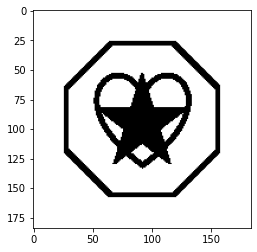

In [398]:
plt.imshow(trixor)

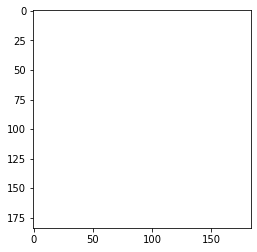

In [409]:
plt.imshow(triple_xor(image_dict["G"], image_dict["H"], answer_list[2]))

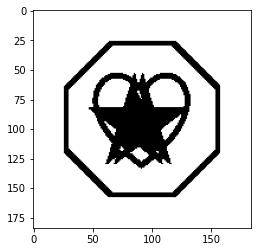

In [399]:
plt.imshow(triple_xor(answer_list[4], image_dict[rest[0]], image_dict[rest[1]]))

In [400]:
[similarity(trixor, triple_xor(answer, image_dict[rest[0]], image_dict[rest[1]])) for answer in answer_list]

[array([[0.66986954]], dtype=float32),
 array([[0.61671305]], dtype=float32),
 array([[0.8699406]], dtype=float32),
 array([[0.88011855]], dtype=float32),
 array([[0.92425996]], dtype=float32),
 array([[0.5048686]], dtype=float32),
 array([[0.52138335]], dtype=float32),
 array([[0.4755825]], dtype=float32)]

1 0.03700862895493773
